# Mini Challenge: Deep Learning for Images and Signals
- Name: Nils Fahrni
- Date: 12.12.2024

## Question: tbd

## Package Usage

In [19]:
#%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "dlbs"

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import wandb
import random

env: "WANDB_NOTEBOOK_NAME"="dlbs"


In [20]:
RANDOM_SEED = 1337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Dataset
Berkeley Deep Drive Dataset: https://arxiv.org/abs/1805.04687

In [5]:
import os

BASE_DATA_PATH = os.path.join('data', 'bdd100k', 'images', '10k')
BASE_LABELS_PATH = os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks')
subfolders = ['train', 'val', 'test']

paths = {
    subfolder: {
        'data_folder': os.path.join(BASE_DATA_PATH, subfolder),
        'labels_folder': os.path.join(BASE_LABELS_PATH, subfolder)
    }
    for subfolder in subfolders
}

### Exploration

[Become one with the data](https://karpathy.github.io/2019/04/25/recipe/#:~:text=1.%20Become%20one%20with%20the%20data)

#### Metrics

In [6]:
from PIL import Image
import numpy as np

resolution_stats = {}

print("--- Image Statistics ---")

for subfolder, folder_paths in paths.items():
    data_folder = folder_paths['data_folder']
    labels_folder = folder_paths['labels_folder']
    
    resolutions = []
    aspect_ratios = []
    total_pixels = []

    for filename in os.listdir(data_folder):
        img_path = os.path.join(data_folder, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            resolutions.append((width, height))
            aspect_ratios.append(width / height)
            total_pixels.append(width * height)

    if resolutions:
        widths, heights = zip(*resolutions)
        min_res = (min(widths), min(heights))
        max_res = (max(widths), max(heights))
        avg_res = (int(np.mean(widths)), int(np.mean(heights)))
        
        resolution_stats[subfolder] = {
            'min_resolution': min_res,
            'max_resolution': max_res,
            'avg_resolution': avg_res,
            'num_images': len(resolutions),
            'min_aspect_ratio': min(aspect_ratios),
            'max_aspect_ratio': max(aspect_ratios),
            'avg_aspect_ratio': np.mean(aspect_ratios),
            'min_total_pixels': min(total_pixels),
            'max_total_pixels': max(total_pixels),
            'avg_total_pixels': int(np.mean(total_pixels))
        }
    
    out = f"Number of images in {subfolder}: {len(resolutions)}"
    if os.path.exists(labels_folder):
        out += f" (with {len(os.listdir(labels_folder))} Labels)"
    else:
        out += " (without Labels)"
    print(out)
    
    if subfolder in resolution_stats:
        stats = resolution_stats[subfolder]
        print(f"Resolution statistics for {subfolder}:")
        print(f"  Min resolution: {stats['min_resolution']}")
        print(f"  Max resolution: {stats['max_resolution']}")
        print(f"  Avg resolution: {stats['avg_resolution']}")
        print(f"  Min aspect ratio (W/H): {stats['min_aspect_ratio']:.2f}")
        print(f"  Max aspect ratio (W/H): {stats['max_aspect_ratio']:.2f}")
        print(f"  Avg aspect ratio (W/H): {stats['avg_aspect_ratio']:.2f}")
        print(f"  Min total pixels: {stats['min_total_pixels']}")
        print(f"  Max total pixels: {stats['max_total_pixels']}")
        print(f"  Avg total pixels: {stats['avg_total_pixels']}")
    print()

--- Image Statistics ---
Number of images in train: 7000 (with 7000 Labels)
Resolution statistics for train:
  Min resolution: (1280, 720)
  Max resolution: (1280, 720)
  Avg resolution: (1280, 720)
  Min aspect ratio (W/H): 1.78
  Max aspect ratio (W/H): 1.78
  Avg aspect ratio (W/H): 1.78
  Min total pixels: 921600
  Max total pixels: 921600
  Avg total pixels: 921600

Number of images in val: 1000 (with 1000 Labels)
Resolution statistics for val:
  Min resolution: (1280, 720)
  Max resolution: (1280, 720)
  Avg resolution: (1280, 720)
  Min aspect ratio (W/H): 1.78
  Max aspect ratio (W/H): 1.78
  Avg aspect ratio (W/H): 1.78
  Min total pixels: 921600
  Max total pixels: 921600
  Avg total pixels: 921600

Number of images in test: 2000 (without Labels)
Resolution statistics for test:
  Min resolution: (1280, 720)
  Max resolution: (1280, 720)
  Avg resolution: (1280, 720)
  Min aspect ratio (W/H): 1.78
  Max aspect ratio (W/H): 1.78
  Avg aspect ratio (W/H): 1.78
  Min total pixels

#### Looking at some samples

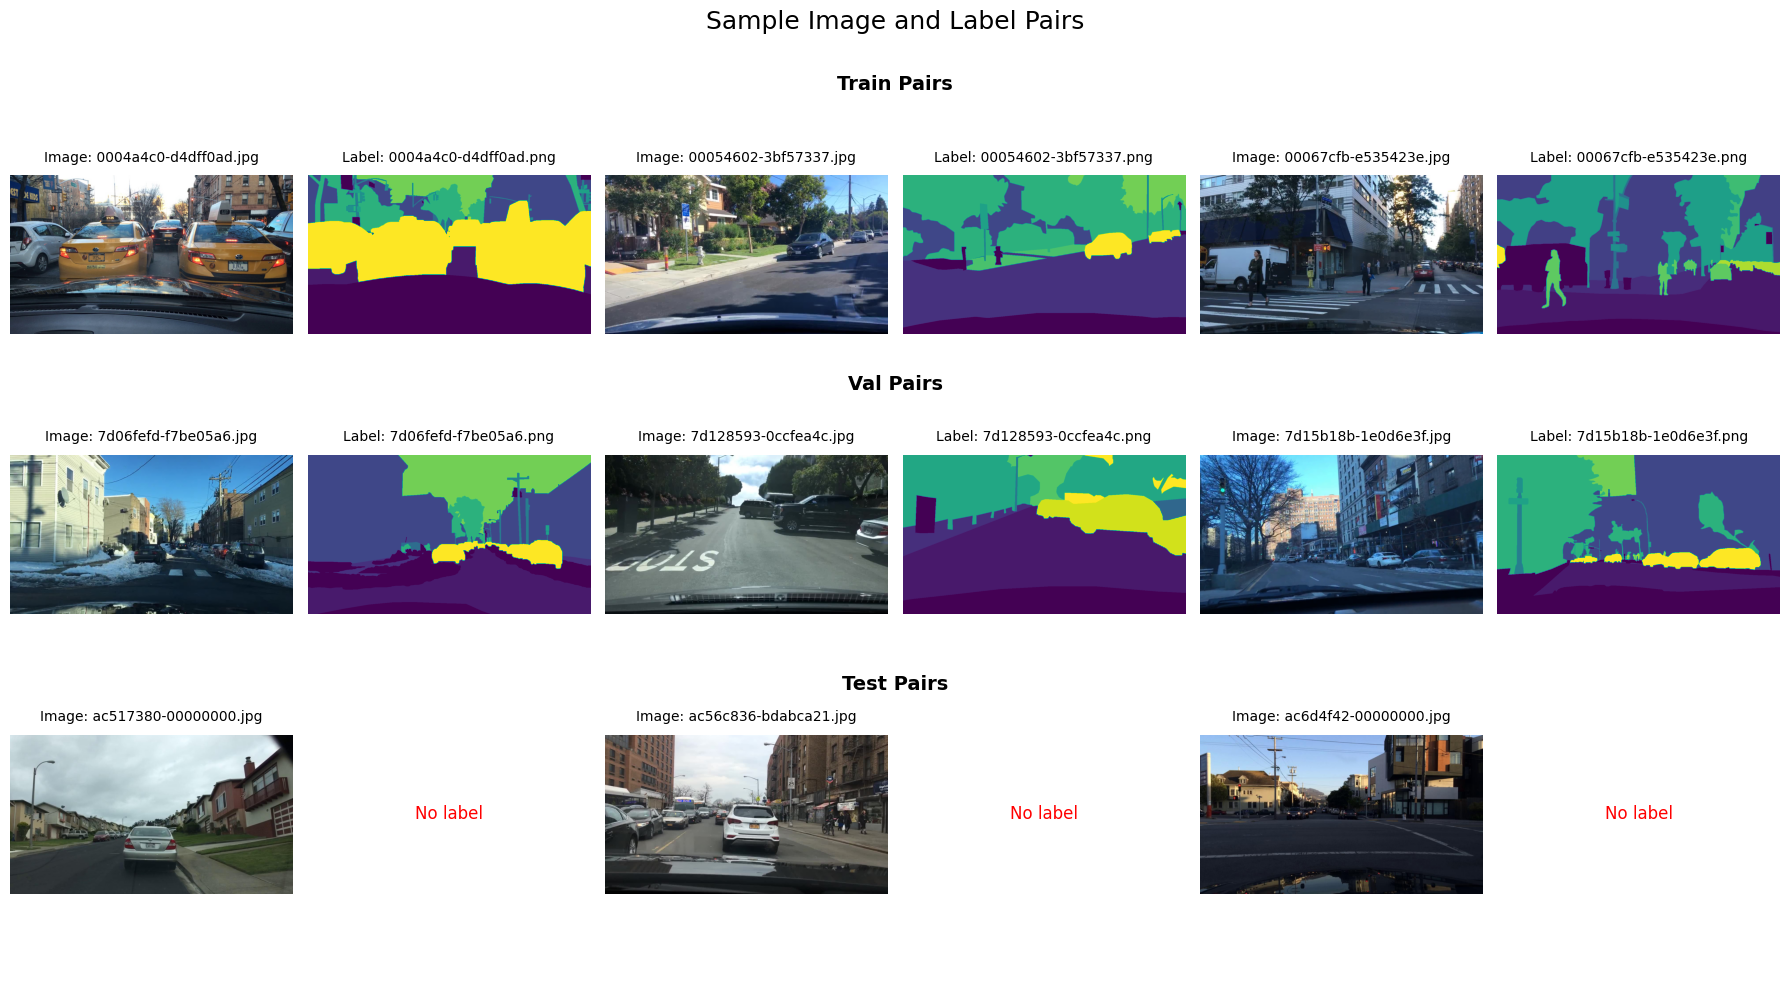

In [7]:
fig, axs = plt.subplots(len(subfolders), 6, figsize=(18, 10))
fig.suptitle('Sample Image and Label Pairs', fontsize=18)

for i, subfolder in enumerate(subfolders):
    data_folder = paths[subfolder]['data_folder']
    labels_folder = paths[subfolder]['labels_folder']
    
    fig.text(0.5, 0.9 - (i * 0.3), f'{subfolder.capitalize()} Pairs', ha='center', fontsize=14, fontweight='bold')

    for j, file in enumerate(os.listdir(data_folder)[:3]):
        img = plt.imread(os.path.join(data_folder, file))
        
        axs[i, j * 2].imshow(img)
        axs[i, j * 2].axis('off')
        
        axs[i, j * 2].set_title(f'Image: {file}', fontsize=10, pad=10, ha='center')

        label_file = os.path.join(labels_folder, file.replace('.jpg', '.png'))
        
        if os.path.exists(label_file) and subfolder != 'test':
            label = plt.imread(label_file)
            axs[i, j * 2 + 1].imshow((label * 255).astype(np.int8))
            axs[i, j * 2 + 1].set_title(f'Label: {file.replace(".jpg", ".png")}', fontsize=10, pad=10, ha='center')
        else:
            axs[i, j * 2 + 1].text(0.5, 0.5, 'No label', color='red', ha='center', va='center', fontsize=12)
            axs[i, j * 2 + 1].set_facecolor("black")
        
        axs[i, j * 2 + 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Spatial Heatmap

https://doc.bdd100k.com/format.html#semantic-segmentation

In [9]:
class_dict = {
    0: "road",
    1: "sidewalk",
    2: "building",
    3: "wall",
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

Processing Classes: 100%|██████████| 19/19 [01:19<00:00,  4.19s/it]


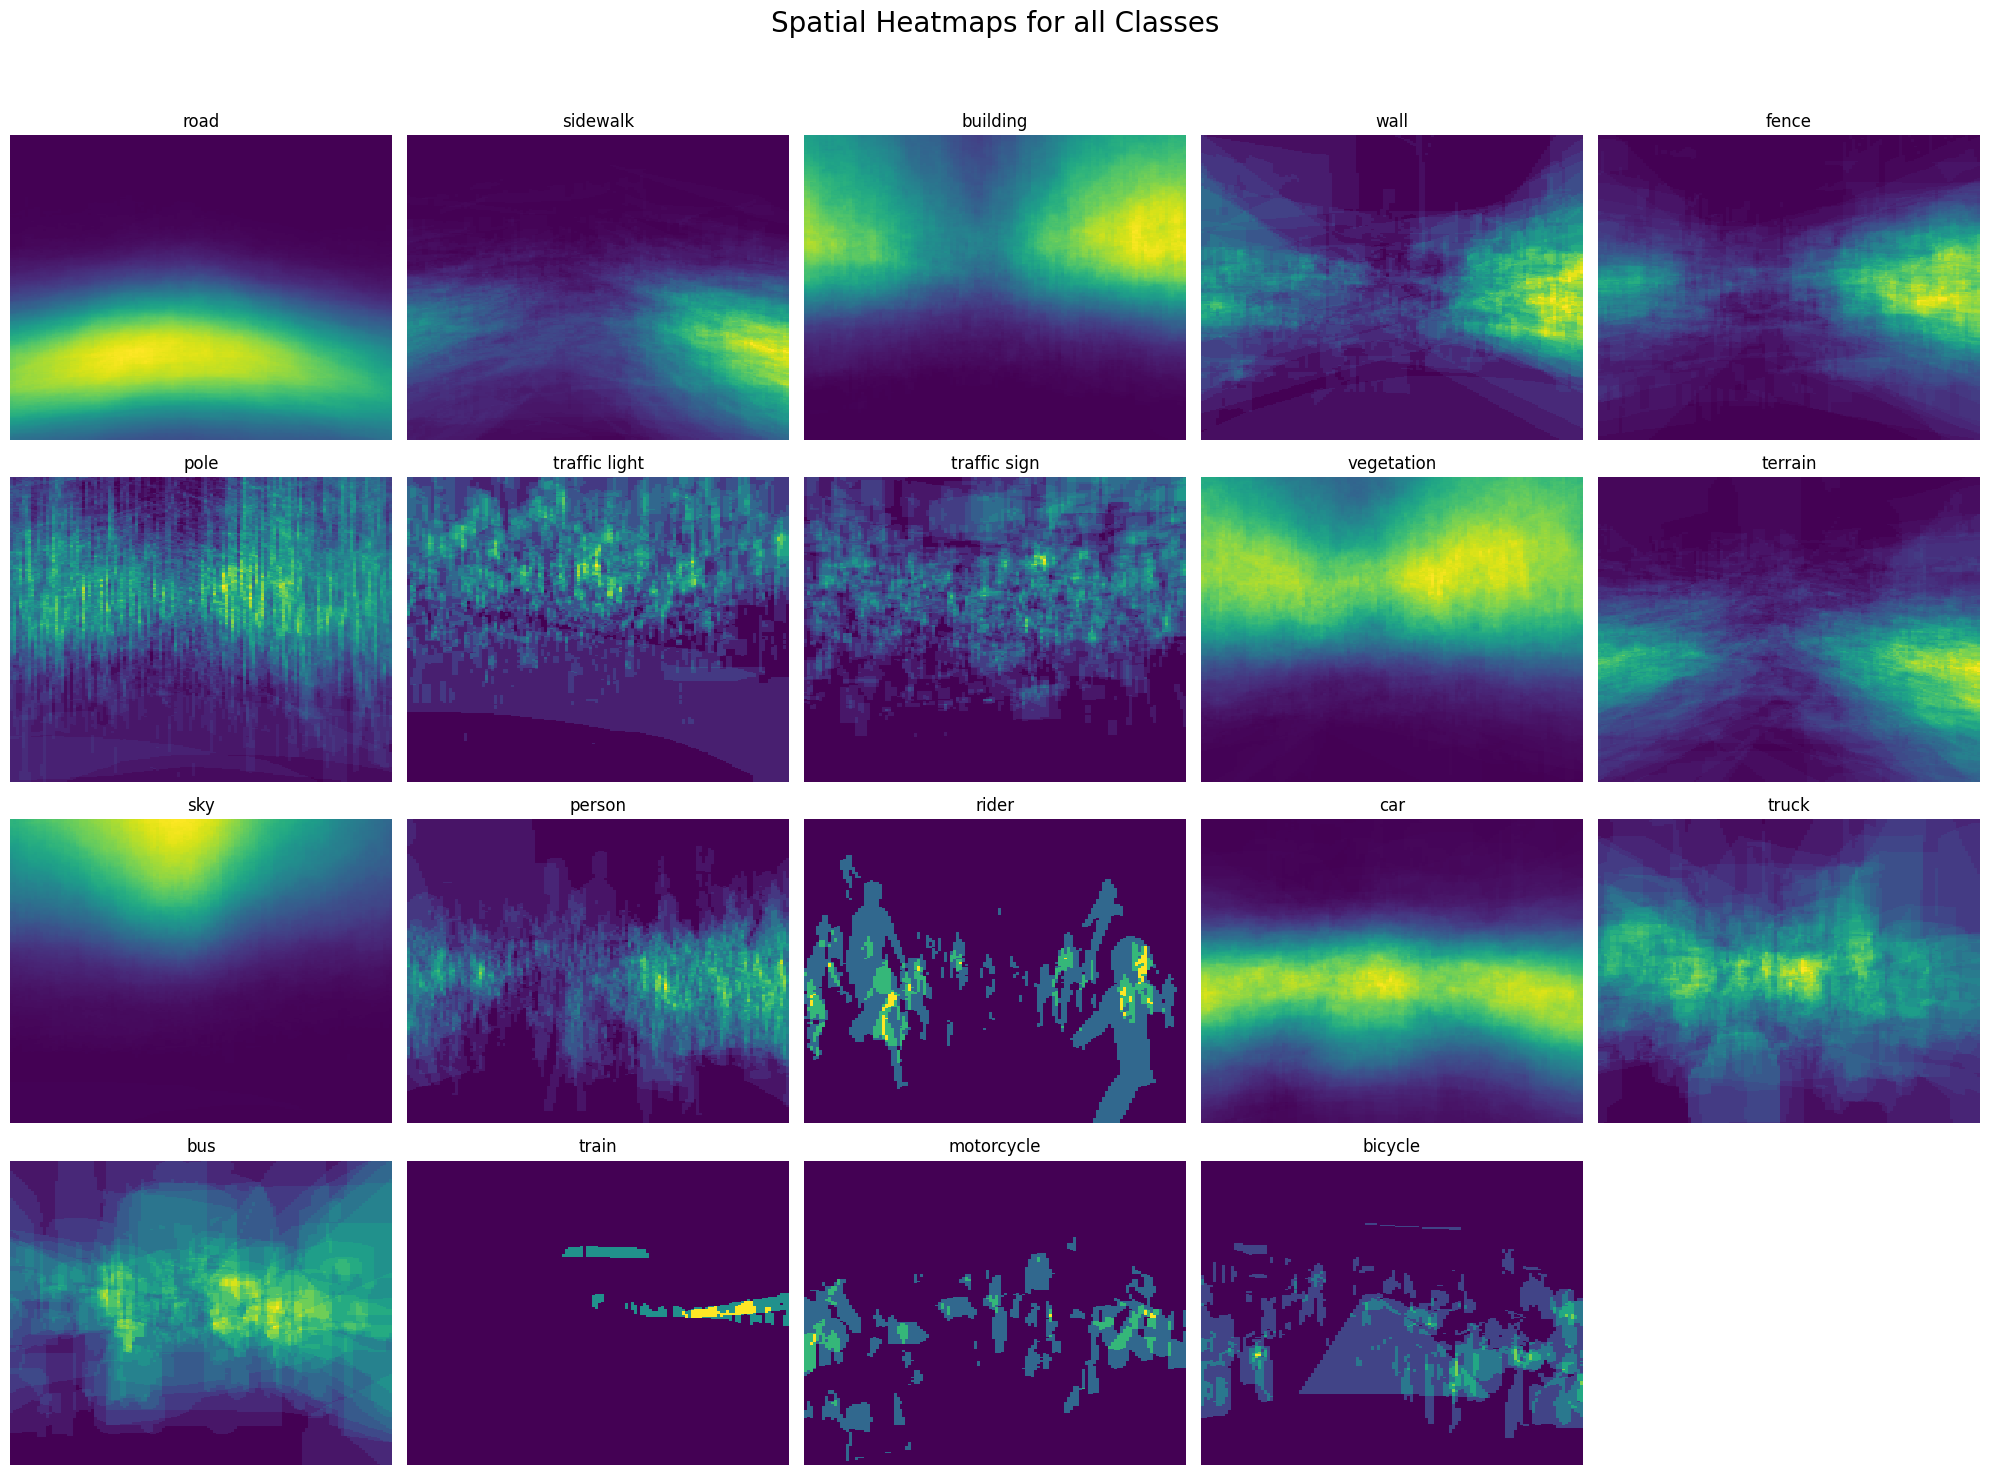

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
from tqdm import tqdm

label_folder = paths['train']['labels_folder']

target_width, target_height = 128, 228
N_SAMPLES = 1000

heatmaps = {class_id: np.zeros((target_height, target_width), dtype=np.float32) for class_id in class_dict.keys()}

for class_id, class_name in tqdm(class_dict.items(), desc="Processing Classes"):
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    sampled_files = random.sample(all_files, min(N_SAMPLES, len(all_files)))
    
    for file in tqdm(sampled_files, desc=f"Sampling {class_name}", leave=False):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)
            
            label_resized = np.array(Image.fromarray(label).resize((target_width, target_height), Image.NEAREST))

            mask = (label_resized == class_id)
            heatmaps[class_id] += mask.astype(np.float32)

    heatmaps[class_id] /= len(sampled_files)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
fig.suptitle("Spatial Heatmaps for all Classes", fontsize=20)

for class_id, class_name in class_dict.items():
    ax = axs[class_id // 5, class_id % 5]
    sns.heatmap(heatmaps[class_id], ax=ax, cmap="viridis", cbar=False)
    ax.set_title(class_name)
    ax.axis('off')

for i in range(len(class_dict), 4 * 5):
    fig.delaxes(axs[i // 5, i % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Co-Occurence

Processing Masks in data\bdd100k\labels\sem_seg\masks\train:   0%|          | 0/7000 [00:00<?, ?it/s]

Processing Masks in data\bdd100k\labels\sem_seg\masks\train: 100%|██████████| 7000/7000 [02:05<00:00, 55.63it/s]
Processing Masks in data\bdd100k\labels\sem_seg\masks\val: 100%|██████████| 1000/1000 [00:18<00:00, 53.75it/s]


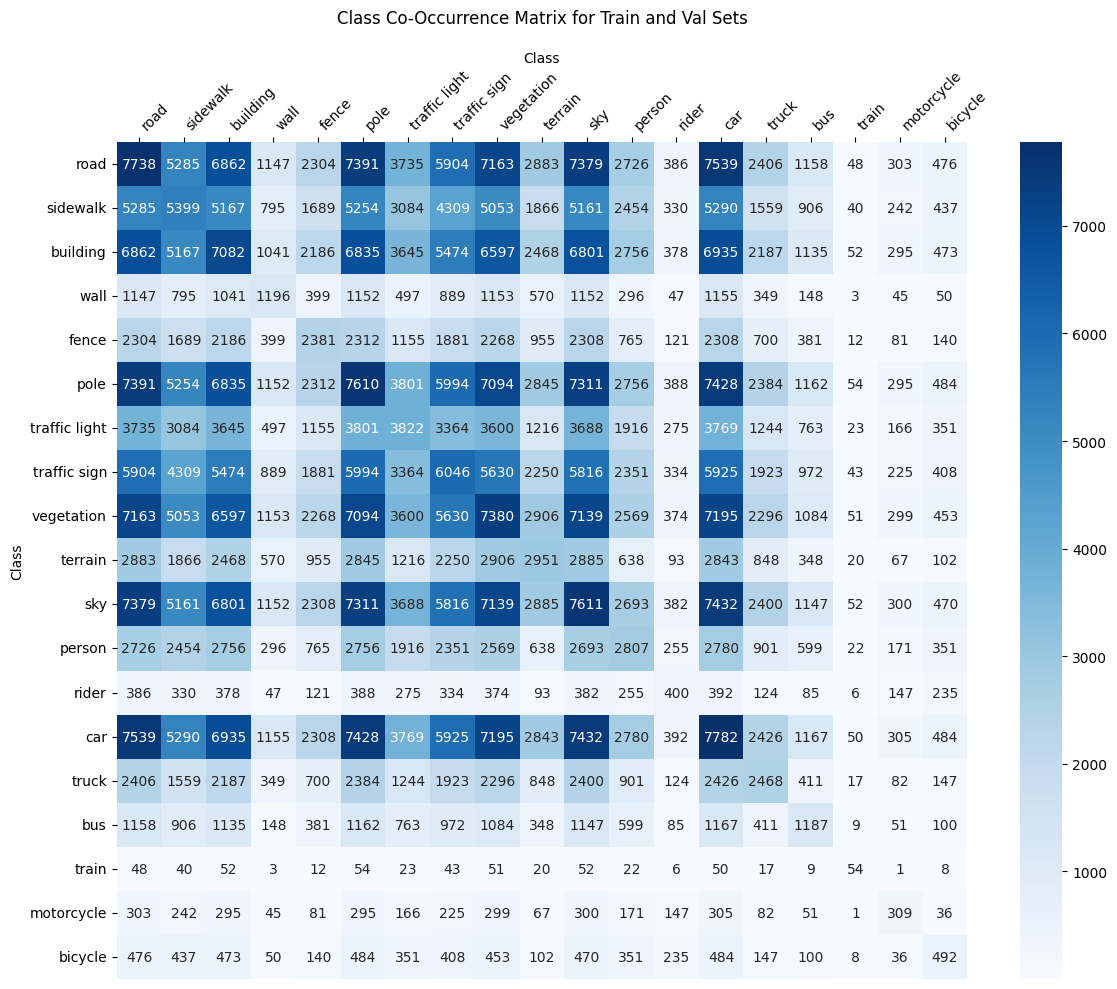

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

label_folders = [paths['train']['labels_folder'], paths['val']['labels_folder']]
num_classes = len(class_dict)
class_names = list(class_dict.values())

co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for label_folder in label_folders:
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    
    for file in tqdm(all_files, desc=f"Processing Masks in {label_folder}"):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)

            unique_classes = np.unique(label)

            for i in range(len(unique_classes)):
                for j in range(i, len(unique_classes)):
                    class_i = unique_classes[i]
                    class_j = unique_classes[j]
                    if class_i < num_classes and class_j < num_classes:
                        co_occurrence_matrix[class_i, class_j] += 1
                        if class_i != class_j:
                            co_occurrence_matrix[class_j, class_i] += 1

plt.figure(figsize=(12, 10))
ax = sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Class Co-Occurrence Matrix for Train and Val Sets", pad=20)
plt.xlabel("Class")
plt.ylabel("Class")

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.xticks(rotation=45, ha="left")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Training and Evaluation Skeleton & Baseline Model

[Set up the end-to-end training/evaluation skeleton + get dumb baselines](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Set%20up%20the%20end%2Dto%2Dend%20training/evaluation%20skeleton%20%2B%20get%20dumb%20baselines)

In [4]:
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

RANDOM_SEED = 1337

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Data Loading & Splitting

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.io import read_image

train_data_folder = os.path.join('data', 'bdd100k', 'images', '10k', 'train')
train_labels_folder = os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks', 'train')

class BDD100KDataset(Dataset):
    def __init__(self, images_dir, labels_dir=None, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = os.listdir(images_dir)
        
        if labels_dir:
            self.label_filenames = os.listdir(labels_dir)
        else:
            self.label_filenames = None

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        try:
            # Load image and convert to RGB
            image_path = os.path.join(self.images_dir, self.image_filenames[idx])
            image = Image.open(image_path).convert('RGB')
            
            # Apply transformations to the image
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

            # Load and process the label if available
            if self.label_filenames:
                label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
                label = Image.open(label_path)  # Keep as is
                
                if self.target_transform:
                    label = self.target_transform(label)
                else:
                    label = torch.tensor(np.array(label), dtype=torch.long)

                return image, label
            else:
                return image
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return None

def label_transform(label):
    # Resize label image with nearest neighbor interpolation
    label = label.resize((128, 128), resample=Image.NEAREST)
    # Convert to numpy array
    label = np.array(label, dtype=np.int64)
    return torch.from_numpy(label)

train_dataset = BDD100KDataset(
    images_dir=train_data_folder, 
    labels_dir=train_labels_folder,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
    target_transform=label_transform
)

# Limiting the dataset to only include the first 10 samples
train_dataset.image_filenames = train_dataset.image_filenames[:100]
if train_dataset.label_filenames:
    train_dataset.label_filenames = train_dataset.label_filenames[:100]

val_dataset = BDD100KDataset(
    images_dir=os.path.join('data', 'bdd100k', 'images', '10k', 'val'),
    labels_dir=os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks', 'val'),
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
    target_transform=label_transform
    )

# Limiting the dataset to only include the first 10 samples
val_dataset.image_filenames = val_dataset.image_filenames[:100]
if val_dataset.label_filenames:
    val_dataset.label_filenames = val_dataset.label_filenames[:100]


#### Training and Evaluation Skeleton

In [23]:
import torch
import wandb
from torchmetrics import JaccardIndex

class Trainer:
    def __init__(self, model, criterion, optimizer, lr, epochs, weight_init, seed, device, verbose, run_name):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.weight_init = weight_init
        self.seed = seed
        self.device = device
        self.verbose = verbose
        self.run_name = run_name

        self.model.to(self.device)

        self.iou_metric = JaccardIndex(num_classes=19, task="multiclass").to(self.device)

        self._set_seed(self.seed)
        wandb.init(project="dlbs", name=self.run_name)

    def _set_seed(self, seed):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    def _initialize_weights(self):
        if self.weight_init:
            self.model.apply(self.weight_init)

    def _train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        self.iou_metric.reset()

        for images, labels in train_loader:
            images, labels = images.to(self.device), labels.to(self.device, dtype=torch.long)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            # Calculate IoU, ignoring 255-labeled pixels
            _, predicted = outputs.max(1)
            mask = labels != 255  # Create a mask for valid pixels
            self.iou_metric.update(predicted[mask], labels[mask])

            # Clear cache to manage GPU memory
            del images, labels, outputs
            torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader)
        epoch_iou = self.iou_metric.compute().item()

        return epoch_loss, epoch_iou

    def _validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        self.iou_metric.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device, dtype=torch.long)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()

                # Calculate IoU, ignoring 255-labeled pixels
                _, predicted = outputs.max(1)
                mask = labels != 255  # Create a mask for valid pixels
                self.iou_metric.update(predicted[mask], labels[mask])

                # Clear cache to manage GPU memory
                del images, labels, outputs
                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(val_loader)
        epoch_iou = self.iou_metric.compute().item()

        return epoch_loss, epoch_iou


    def run(self, train_loader, val_loader):
        self._initialize_weights()

        for epoch in range(self.epochs):
            train_loss, train_iou = self._train_epoch(train_loader)
            val_loss, val_iou = self._validate_epoch(val_loader)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.epochs} - "
                      f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} - "
                      f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_iou": train_iou,
                "val_loss": val_loss,
                "val_iou": val_iou
            })

    def test(self, test_loader):
        test_loss, test_iou = self._validate_epoch(test_loader)

        print(f"Test Loss: {test_loss:.4f} - Test IoU: {test_iou:.4f}")
        wandb.log({
            "test_loss": test_loss,
            "test_iou": test_iou
        })

    def _save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)


#### Baseline (Tiny-)U-Net

In [25]:
import torch.optim as optim

model = UNetBaseline(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Trainer(model, criterion, optimizer, lr=1e-3, epochs=50, weight_init=None, seed=RANDOM_SEED, device=device, verbose=True, run_name="unet_baseline").run(train_dataloader, val_dataloader)

Epoch 1/50 - Train Loss: 2.9017, Train IoU: 0.0172 - Val Loss: 2.2674, Val IoU: 0.0124
Epoch 2/50 - Train Loss: 2.2518, Train IoU: 0.0339 - Val Loss: 2.4004, Val IoU: 0.0182
Epoch 3/50 - Train Loss: 2.0734, Train IoU: 0.0130 - Val Loss: 2.0258, Val IoU: 0.0231
Epoch 4/50 - Train Loss: 1.6893, Train IoU: 0.0249 - Val Loss: 2.0569, Val IoU: 0.0152
Epoch 5/50 - Train Loss: 1.5676, Train IoU: 0.0440 - Val Loss: 1.9523, Val IoU: 0.0327
Epoch 6/50 - Train Loss: 1.4308, Train IoU: 0.0519 - Val Loss: 2.0399, Val IoU: 0.0347
Epoch 7/50 - Train Loss: 1.3669, Train IoU: 0.0637 - Val Loss: 1.8755, Val IoU: 0.0489
Epoch 8/50 - Train Loss: 1.3895, Train IoU: 0.0732 - Val Loss: 1.7814, Val IoU: 0.0595
Epoch 9/50 - Train Loss: 1.2820, Train IoU: 0.0820 - Val Loss: 1.7422, Val IoU: 0.0626
Epoch 10/50 - Train Loss: 1.1751, Train IoU: 0.0796 - Val Loss: 1.7674, Val IoU: 0.0581
Epoch 11/50 - Train Loss: 1.1775, Train IoU: 0.0893 - Val Loss: 1.7352, Val IoU: 0.0670
Epoch 12/50 - Train Loss: 1.1172, Train I

### Overfit

[Overfit](https://karpathy.github.io/2019/04/25/recipe/#:~:text=3.-,Overfit,-At%20this%20stage)

### Regularization

[Regularize](https://karpathy.github.io/2019/04/25/recipe/#:~:text=4.-,Regularize,-Ideally%2C%20we%20are)

### Tuning the model

[Tune](https://karpathy.github.io/2019/04/25/recipe/#:~:text=5.-,Tune,-You%20should%20now)

### Ensembles & Leave it training

[Squeeze out the juice](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Squeeze%20out%20the%20juice)